# Load and preprocess the Yoga dataset you used for classification

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import optimizers
from keras import regularizers
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Computer Vision/Assignments'

# Select a subset of images (5-10) that you want to apply style transfer to.

I created a subfolder of 6 images I selected.

In [4]:
import os

# Subset directory

subset_dir = os.path.abspath(f'{data_dir}/styletransfer_subset')
print(f"Checking directory: {subset_dir}")

# List files in directory
print(f"Files found: {os.listdir(subset_dir)}")

Checking directory: /content/drive/MyDrive/Computer Vision/Assignments/styletransfer_subset
Files found: ['adho_muka_svanasana.png', 'bitilisana.png', 'phalakasana.png', 'ustrasana.png', 'uttana_shishosana.png', 'setu_bandha_sarvangasana.png']


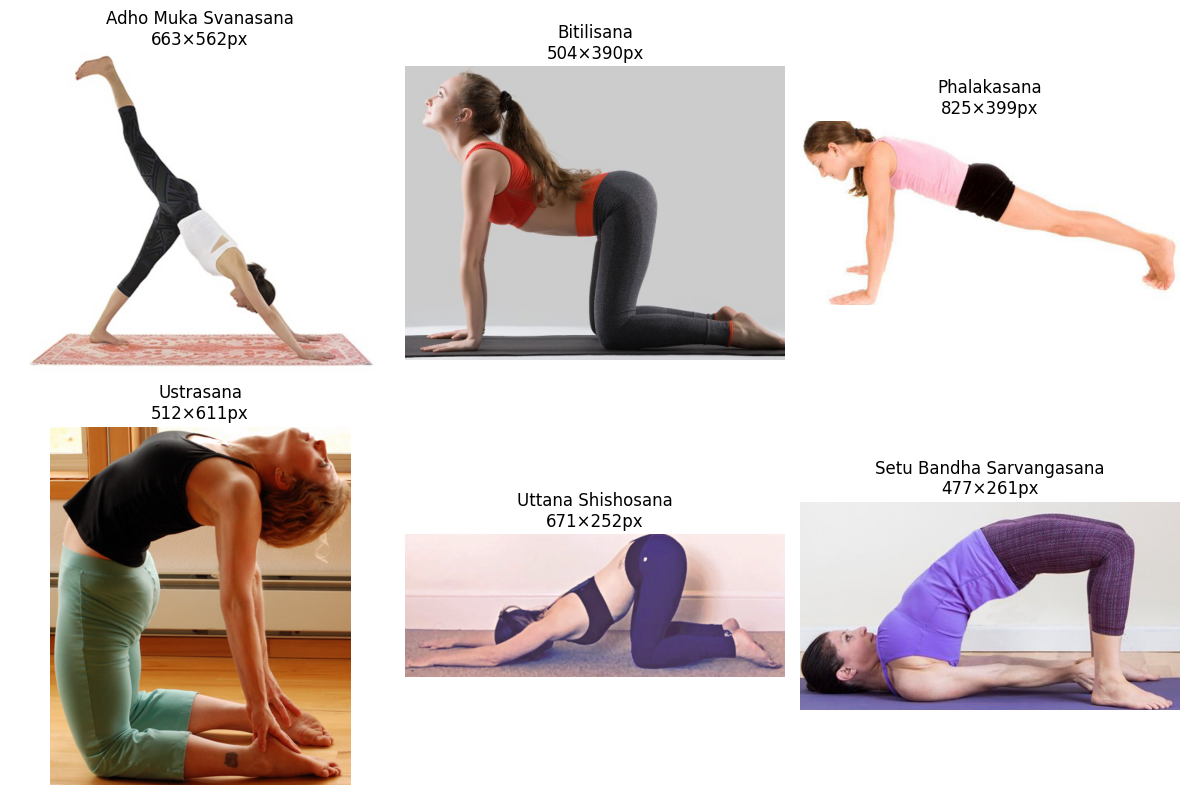

In [5]:
from tensorflow.keras.preprocessing.image import load_img
import os
import matplotlib.pyplot as plt

# Display original yoga images before preprocessing, with size printed
plt.figure(figsize=(12, 8))
for i, img_name in enumerate(os.listdir(subset_dir)):
    img_path = os.path.join(subset_dir, img_name)

    # Load image without preprocessing (PIL Image)
    img = load_img(img_path)
    width, height = img.size

    # Display
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    # include size in the title
    title = img_name.split('.')[0].replace('_', ' ').title()
    plt.title(f"{title}\n{width}×{height}px")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Load style image

#style_path = os.path.join(data_dir, "monet_waterlilies.jpg")
#style_path = os.path.join(data_dir, "seurat_sunday_afternoon.jpg")
#style_path = os.path.join(data_dir, "klimt_the_kiss.jpg")
style_path = os.path.join(data_dir, "bright_image.png")

Original size: 481×637px
Resized size: 512×512px


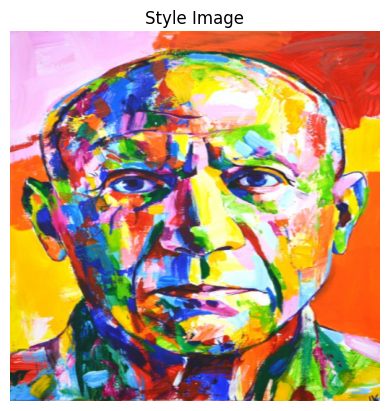

In [7]:
# Show original style image before preprocessing

# Read & decode without resizing to get the original size
raw = tf.io.read_file(style_path)
orig = tf.image.decode_image(raw, channels=3, expand_animations=False)
orig_height, orig_width = orig.shape[0], orig.shape[1]
print(f"Original size: {orig_width}×{orig_height}px")

# Resize to 512×512
style_img = tf.image.resize(orig, [512, 512])
style_img = tf.cast(style_img, tf.float32)
print(f"Resized size: {style_img.shape[1]}×{style_img.shape[0]}px")

# Display
plt.imshow(style_img / 255.0)
plt.axis('off')
plt.title("Style Image")
plt.show()

In [8]:
# VGG19
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [9]:
# Helper functions

# Resize + VGG preprocess
def load_and_preprocess(path, max_dim=512):
    img = Image.open(path).convert("RGB")
    scale = max_dim / max(img.size)
    img = img.resize((int(img.width*scale), int(img.height*scale)), Image.LANCZOS)
    arr = vgg19.preprocess_input(np.array(img))
    return tf.expand_dims(arr, axis=0)

# Undo VGG preprocess for display
def deprocess(x):
    x = x.numpy().squeeze()
    x[..., 0] += 103.939; x[..., 1] += 116.779; x[..., 2] += 123.68
    x = x[..., ::-1]
    return np.clip(x,0,255).astype("uint8")

# Gram matrix
def gram_matrix(t):
    b,h,w,c = t.shape
    f = tf.reshape(t, [b, h*w, c])
    g = tf.matmul(f, f, transpose_a=True)
    return g / tf.cast(h*w*c, tf.float32)

In [10]:
# Load and preprocess images

style_tensor = load_and_preprocess(style_path)

content_tensors = {
    fn: load_and_preprocess(os.path.join(subset_dir, fn))
    for fn in os.listdir(subset_dir)
    if fn.lower().endswith(('.png','jpg','jpeg'))
}

# Use a pre-trained CNN (e.g., VGG-19) to extract the content and style features from the images.


In [16]:
# VGG19 and layer names
vgg = vgg19.VGG19(include_top=False, weights="imagenet")
vgg.trainable = False
style_layers   = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
content_layer  = 'block5_conv2'

# extractor model
outputs = [vgg.get_layer(n).output for n in style_layers + [content_layer]]
extractor = tf.keras.Model(vgg.input, outputs)

In [17]:
# Style Gram targets
style_feats = extractor(style_tensor)[:len(style_layers)]
style_targets = [gram_matrix(f) for f in style_feats]
# Content targets per yoga image
content_targets = {
    name: extractor(t)[len(style_layers):][0]
    for name,t in content_tensors.items()
}

In [18]:
# Style‐transfer function
def style_transfer(
    content, content_target, style_tgts,
    cw=1e3, sw=1e1, epochs=100, steps=20
):
    img = tf.Variable(content)
    # Dummy LR to override in each epoch
    opt = tf.optimizers.Adam(learning_rate=1.0)

    for epoch in range(epochs):
        new_lr = 15.0 if epoch < (epochs // 2) else 5.0
        opt.learning_rate.assign(new_lr)

        for _ in range(steps):
            with tf.GradientTape() as tape:
                feats = extractor(img)
                s_feats = feats[:len(style_layers)]
                c_feat  = feats[len(style_layers):][0]

                # style loss
                sl = tf.add_n([
                    tf.reduce_mean((gram_matrix(sf) - tgt)**2)
                    for sf, tgt in zip(s_feats, style_tgts)
                ]) / len(style_layers)

                # content loss
                cl = tf.reduce_mean((c_feat - content_target)**2)

                loss = sw * sl + cw * cl

            grads = tape.gradient(loss, img)
            opt.apply_gradients([(grads, img)])
            img.assign(tf.clip_by_value(img, 0.0, 255.0))

        if epoch % 10 == 0 or epoch == epochs - 1:
            tf.print(f"[Epoch {epoch:02d}] lr={new_lr:.1f}  loss={loss:.2f}")

    return img

# Implement the style transfer algorithm, which optimizes a new image to combine the content of a yoga pose image and the style of an artwork.

In [19]:
# Run on all yoga images
results = {
  name: style_transfer(
    content_tensors[name], content_targets[name], style_targets
  )
  for name in content_tensors
}

[Epoch 00] lr=15.0  loss=1060863.50
[Epoch 10] lr=15.0  loss=247396.84
[Epoch 20] lr=15.0  loss=198397.00
[Epoch 30] lr=15.0  loss=329352.44
[Epoch 40] lr=15.0  loss=192901.47
[Epoch 50] lr=5.0  loss=128011.08
[Epoch 60] lr=5.0  loss=103918.09
[Epoch 70] lr=5.0  loss=100959.86
[Epoch 80] lr=5.0  loss=98879.05
[Epoch 90] lr=5.0  loss=97719.91
[Epoch 99] lr=5.0  loss=97745.39
[Epoch 00] lr=15.0  loss=910177.00
[Epoch 10] lr=15.0  loss=174195.62
[Epoch 20] lr=15.0  loss=224633.34
[Epoch 30] lr=15.0  loss=275066.62
[Epoch 40] lr=15.0  loss=183024.34
[Epoch 50] lr=5.0  loss=101513.41
[Epoch 60] lr=5.0  loss=84599.34
[Epoch 70] lr=5.0  loss=81759.66
[Epoch 80] lr=5.0  loss=80178.46
[Epoch 90] lr=5.0  loss=79591.46
[Epoch 99] lr=5.0  loss=78788.80
[Epoch 00] lr=15.0  loss=1035538.12
[Epoch 10] lr=15.0  loss=264529.53
[Epoch 20] lr=15.0  loss=208350.53
[Epoch 30] lr=15.0  loss=205712.86
[Epoch 40] lr=15.0  loss=206002.25
[Epoch 50] lr=5.0  loss=138767.52
[Epoch 60] lr=5.0  loss=124998.37
[Epoc

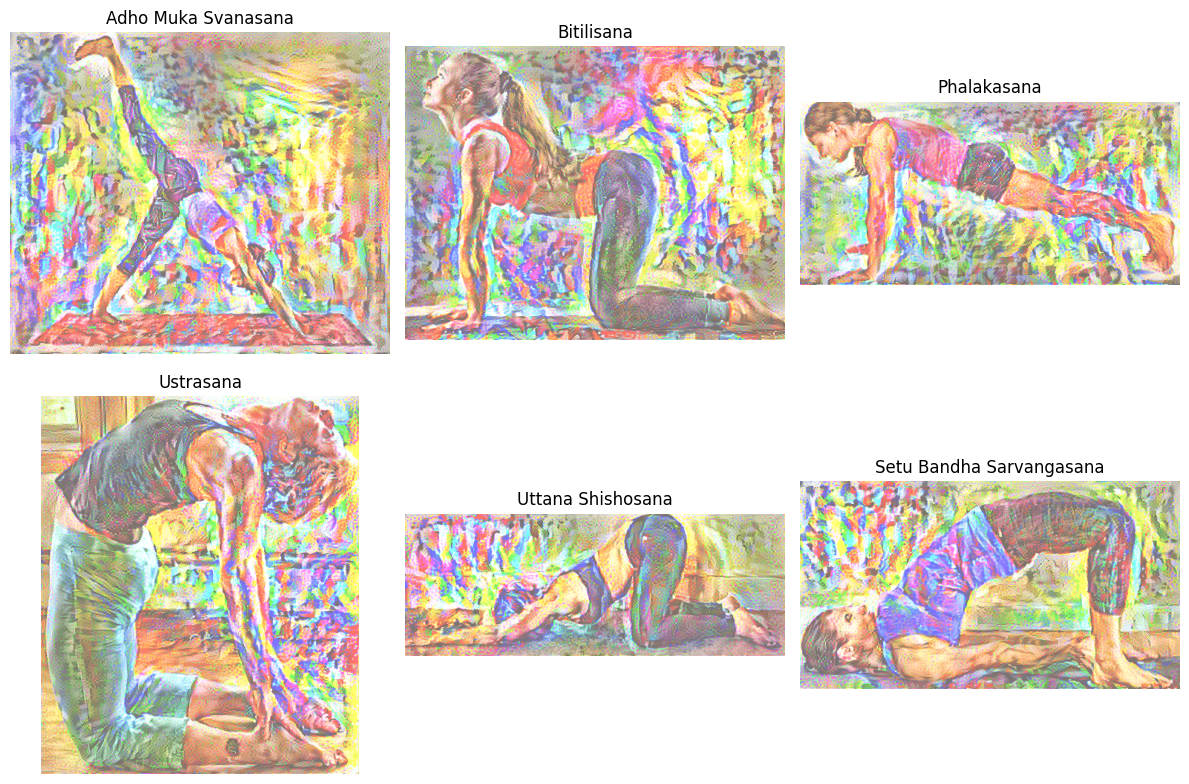

In [20]:
# Display final 6 results in grid
n = len(results); cols=3; rows=(n+cols-1)//cols
plt.figure(figsize=(cols*4, rows*4))
for i,(name,img_var) in enumerate(results.items()):
    ax = plt.subplot(rows,cols,i+1)
    ax.imshow(deprocess(img_var))
    ax.set_title(name.split(".")[0].replace("_"," ").title())
    ax.axis("off")
plt.tight_layout()
plt.show()

# Fine-tune the style transfer model to improve results (e.g., by adjusting the weights of the content and style loss).

In [28]:
# One image to process
name = list(content_tensors.keys())[3]
content_tensor = content_tensors[name]

# Extract its content target
outputs = extractor(content_tensor)
content_target = outputs[len(style_layers)]

# Precompute style targets once
style_outputs = extractor(style_tensor)[:len(style_layers)]
style_tgts = [gram_matrix(f) for f in style_outputs]

# Content‐only experiments (style_weight=0, tv_weight=0)
content_configs = [
    ("High Content Weight",   1e5),
    ("Medium Content Weight", 1e4),
    ("Low Content Weight",    1e2),
]
content_results = {}
for label, cw in content_configs:
    tf.print(f"\n→ {label}: cw={cw}")
    out = style_transfer(
        content        = content_tensor,
        content_target = content_target,
        style_tgts     = style_tgts,
        cw             = cw,
        sw             = 0.0,      # no style
        epochs         = 50,
        steps          = 20
    )
    content_results[label] = out


→ High Content Weight: cw=100000.0
[Epoch 00] lr=15.0  loss=66679036.00
[Epoch 10] lr=15.0  loss=10768022.00
[Epoch 20] lr=15.0  loss=6699972.00
[Epoch 30] lr=5.0  loss=2905410.75
[Epoch 40] lr=5.0  loss=2437046.25
[Epoch 49] lr=5.0  loss=2248256.75

→ Medium Content Weight: cw=10000.0
[Epoch 00] lr=15.0  loss=6669251.50
[Epoch 10] lr=15.0  loss=799172.69
[Epoch 20] lr=15.0  loss=682390.81
[Epoch 30] lr=5.0  loss=285714.75
[Epoch 40] lr=5.0  loss=238379.95
[Epoch 49] lr=5.0  loss=235133.53

→ Low Content Weight: cw=100.0
[Epoch 00] lr=15.0  loss=66632.90
[Epoch 10] lr=15.0  loss=8640.74
[Epoch 20] lr=15.0  loss=6073.21
[Epoch 30] lr=5.0  loss=3005.66
[Epoch 40] lr=5.0  loss=2441.00
[Epoch 49] lr=5.0  loss=2398.23


In [23]:
# One image to process
name = list(content_tensors.keys())[3]
content_tensor = content_tensors[name]

# Extract its content target
outputs = extractor(content_tensor)
content_target = outputs[len(style_layers)]

# Precompute style targets once
style_outputs = extractor(style_tensor)[:len(style_layers)]
style_tgts = [gram_matrix(f) for f in style_outputs]

# Style‐only experiments (content_weight fixed)
style_configs = [
    ("High Style Weight",    1e2,  10.0),
    ("Medium Style Weight",  1e2,   1e-1),
    ("Low Style Weight",     1e2,   1e-3),
]
style_results = {}
for label, cw, sw in style_configs:
    tf.print(f"\n→ {label}: cw={cw}, sw={sw}")
    out = style_transfer(
        content        = content_tensor,
        content_target = content_target,
        style_tgts     = style_tgts,
        cw             = cw,
        sw             = sw,
        epochs         = 50,
        steps          = 20
    )
    style_results[label] = out


→ High Style Weight: cw=100.0, sw=10.0
[Epoch 00] lr=15.0  loss=420385.34
[Epoch 10] lr=15.0  loss=77997.44
[Epoch 20] lr=15.0  loss=67773.31
[Epoch 30] lr=5.0  loss=45093.25
[Epoch 40] lr=5.0  loss=42334.61
[Epoch 49] lr=5.0  loss=40808.27

→ Medium Style Weight: cw=100.0, sw=0.1
[Epoch 00] lr=15.0  loss=89555.63
[Epoch 10] lr=15.0  loss=16375.02
[Epoch 20] lr=15.0  loss=13179.59
[Epoch 30] lr=5.0  loss=7513.47
[Epoch 40] lr=5.0  loss=6623.24
[Epoch 49] lr=5.0  loss=6515.43

→ Low Style Weight: cw=100.0, sw=0.001
[Epoch 00] lr=15.0  loss=61353.30
[Epoch 10] lr=15.0  loss=8377.37
[Epoch 20] lr=15.0  loss=6491.33
[Epoch 30] lr=5.0  loss=3231.06
[Epoch 40] lr=5.0  loss=2704.17
[Epoch 49] lr=5.0  loss=2505.72


# Compare the results to see how well the style has been transferred while maintaining the original content (yoga poses).

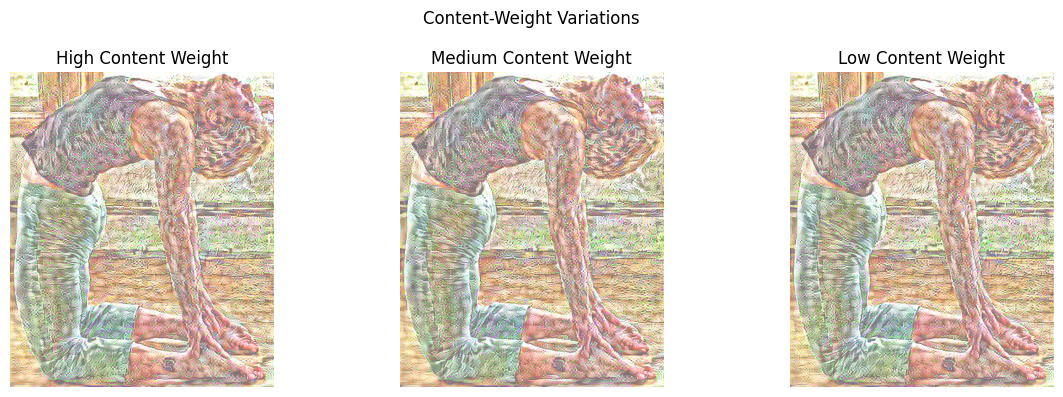

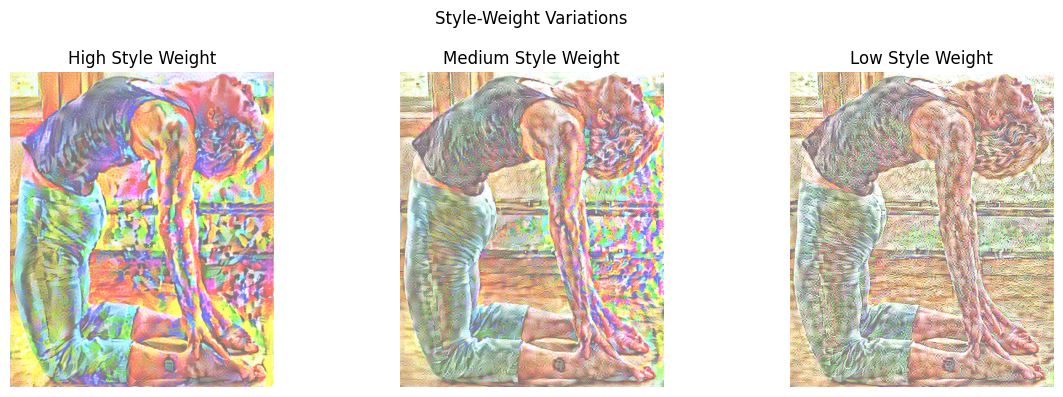

In [29]:
import matplotlib.pyplot as plt

def show_grid(results, title):
    plt.figure(figsize=(len(results)*4, 4))
    for i, (label, img_var) in enumerate(results.items()):
        ax = plt.subplot(1, len(results), i+1)
        ax.imshow(deprocess(img_var))
        ax.set_title(label)
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_grid(content_results, "Content-Weight Variations")
show_grid(style_results,   "Style-Weight Variations")

# Visualize the results (shown above) and discuss how different styles affect the quality and preservation of the yoga poses.

* High content weight - optimizer preserves the original yoga pose structure with clear outlines of the clothes, face, feet. There is a light application of style.
* Low content weight - the style is slightly stronger in this one. The pose is  less preserved, and the body is blurred a bit more by the style.
* High style weight - Yoga pose is heavily impacted by the bold colors of the style image, blending some of the background into the strokes.
* Low style weight - Yoga silhouette is in tact, with some mild coloring taken from style image. Content is preserved.

In [ ]:
!jupyter nbconvert --to html "/content/Assignment3_StyleTransfer_HiraStanley.ipynb"

[NbConvertApp] Converting notebook /content/Assignment3_StyleTransfer_HiraStanley.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 35 image(s).
[NbConvertApp] Writing 15059489 bytes to /content/Assignment3_StyleTransfer_HiraStanley.html
